In [1]:
%cd /Users/gwg/dmcm
%matplotlib inline

/Users/gwg/dmcm


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   PIL import Image
import random
import seaborn as sns
import torch

from   data import GTExConfig, GTExDataset, loader
from   models import DPCCA

In [3]:
cfg = GTExConfig()

directory = 'experiments/20190305_gtexv6_celeba/'\
            'gtex_mode-dpcca_seed-0_latent_dim-10_lr-0.0001_l1_coef-0.0_em_iters-1'

state = torch.load(directory + '/model.pt', map_location={'cuda:0': 'cpu'})
model = DPCCA(cfg, latent_dim=10, use_gene_net=True)
model.load_state_dict(state)

In [4]:
train_loader, test_loader = loader.get_data_loaders(cfg,
                                                    batch_size=128,
                                                    num_workers=1,
                                                    pin_memory=False,
                                                    directory=directory)
dataset = train_loader.dataset

In [6]:
state = torch.load(directory + '/model.pt', map_location={'cuda:0': 'cpu'})
model = DPCCA(cfg, latent_dim=10, use_gene_net=True)
model.load_state_dict(state)

def embed(tissue_target):
    n = 0
    for i in range(len(dataset)):
        if dataset.tissues[i] != tissue_target:
            continue
        n += 1

    X1 = torch.Tensor(n, cfg.N_CHANNELS, cfg.IMG_SIZE, cfg.IMG_SIZE)
    X2 = torch.Tensor(n, cfg.N_GENES)

    j = 0
    gtex_names = []
    for i in range(len(dataset)):
        if dataset.tissues[i] != tissue_target:
            continue
        x1, x2 = dataset[i]
        X1[j] = x1
        X2[j] = x2
        j += 1

        full_name = dataset.names[i]
        parts = full_name.split('-')
        gtex_name = '-'.join(parts[:2])
        gtex_names.append(gtex_name)

    Z = model.estimate_z_given_x([X1, X2], threshold=None).detach()
    return Z, gtex_names

In [7]:
TISSUES = {
    'Adipose Tissue' : ['adiposesubcutaneous', 'adiposevisceralomentum'],
    'Adrenal Gland'  : ['adrenalgland'],
    'Blood Vessel'   : ['wholeblood'],
    'Brain'          : ['braincerebellum', 'braincerebellarhemisphere', 'braincortex'],
    'Colon'          : ['colonsigmoid'],
    'Esophagus'      : ['esophagusmucosa', 'esophagusmuscularis'],
    'Heart'          : ['heartatrialappendage', 'heartleftventricle'],
    'Kidney'         : [],
    'Liver'          : ['liver'],
    'Lung'           : ['lung'],
    'Muscle'         : ['muscleskeletal'],
    'Ovary'          : ['ovary'],
    'Pancreas'       : ['pancreas'],
    'Pituitary'      : ['pituitary'],
    'Prostate'       : ['prostate'],
    'Salivary Gland' : [],
    'Small Intestine': ['smallintestineterminalileum'],
    'Spleen'         : ['spleen'],
    'Stomach'        : ['stomach'],
    'Testis'         : ['testis'],
    'Thyroid'        : ['thyroid'],
    'Uterus'         : ['uterus'],
    'Vagina'         : ['vagina']
}

In [8]:
covariates = set()
for tissue in TISSUES.keys():
    for tiss_name in TISSUES[tissue]:
        fpath  = 'data/gtex/covariates/%s_Analysis.covariates.txt' % tiss_name
        df = pd.read_csv(fpath, sep='\t')
        covariates = covariates.union(set(df['ID'].values))
print(covariates)

{'InferredCov9', 'InferredCov30', 'InferredCov10', 'InferredCov1', 'InferredCov27', 'InferredCov15', 'InferredCov3', 'InferredCov20', 'InferredCov22', 'Platform', 'InferredCov25', 'C3', 'InferredCov18', 'InferredCov5', 'C2', 'C1', 'gender', 'InferredCov26', 'InferredCov31', 'InferredCov7', 'InferredCov32', 'InferredCov29', 'InferredCov2', 'InferredCov16', 'InferredCov24', 'InferredCov17', 'InferredCov34', 'InferredCov14', 'InferredCov33', 'InferredCov21', 'InferredCov19', 'InferredCov8', 'InferredCov23', 'InferredCov13', 'InferredCov35', 'InferredCov12', 'InferredCov11', 'InferredCov28', 'InferredCov6', 'InferredCov4'}


In [40]:
from scipy.stats import pearsonr

TISSUES = {
    'Adipose Tissue' : ['adiposesubcutaneous', 'adiposevisceralomentum'],
    'Adrenal Gland'  : ['adrenalgland'],
    'Blood Vessel'   : ['wholeblood'],
    'Brain'          : ['braincerebellum', 'braincerebellarhemisphere', 'braincortex'],
    'Colon'          : ['colonsigmoid'],
    'Esophagus'      : ['esophagusmucosa', 'esophagusmuscularis'],
    'Heart'          : ['heartatrialappendage', 'heartleftventricle'],
    'Kidney'         : [],
    'Liver'          : ['liver'],
    'Lung'           : ['lung'],
    'Muscle'         : ['muscleskeletal'],
    'Ovary'          : ['ovary'],
    'Pancreas'       : ['pancreas'],
    'Pituitary'      : ['pituitary'],
    'Prostate'       : ['prostate'],
    'Salivary Gland' : [],
    'Small Intestine': ['smallintestineterminalileum'],
    'Spleen'         : ['spleen'],
    'Stomach'        : ['stomach'],
    'Testis'         : ['testis'],
    'Thyroid'        : ['thyroid'],
    'Uterus'         : ['uterus'],
    'Vagina'         : ['vagina']
}

def build_correlation_matrix(tiss_name):
    
    columns = [c for c in range(0, 30)]
    results_df = pd.DataFrame(index=covariates, columns=columns)
    results_df = results_df.fillna(0).astype(np.float64)

    print('=' * 80)
    print(tiss_name)

    fpath  = 'data/gtex/covariates/%s_Analysis.covariates.txt' % tiss_name
    df = pd.read_csv(fpath, sep='\t')

    Z, gtex_names = embed(tissue)

    for cov_id in range(len(df.index)):
        for factor_idx in range(0, 30):
            cov_vals = []
            z_vals   = []
            for name, zval in zip(gtex_names, Z.t()[factor_idx].numpy()):
                try:
                    col = df[name]
                    cov_vals.append(col[cov_id])
                    z_vals.append(zval)
                except KeyError:
                    pass

            corr, pval = pearsonr(cov_vals, z_vals)
            # if pval < 0.05:
            cov_name = df['ID'][cov_id]
            results_df[factor_idx][cov_name] = corr
    
    return results_df

adiposesubcutaneous


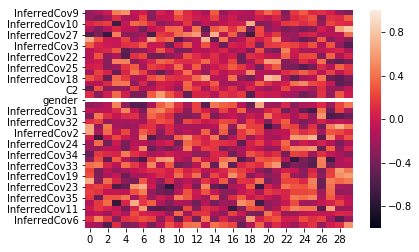

In [41]:
df = build_correlation_matrix(TISSUES['Adipose Tissue'][0])
sns.heatmap(df, vmin=-1, vmax=1)

adiposevisceralomentum


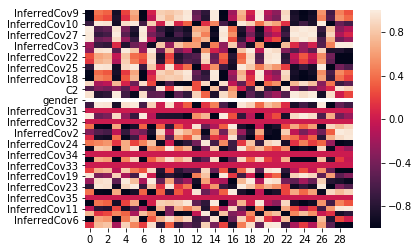

In [42]:
df = build_correlation_matrix(TISSUES['Adipose Tissue'][1])
sns.heatmap(df, vmin=-1, vmax=1)

adrenalgland


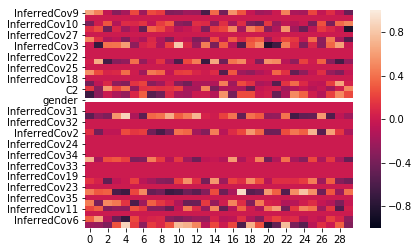

In [44]:
df = build_correlation_matrix(TISSUES['Adrenal Gland'][0])
sns.heatmap(df, vmin=-1, vmax=1)

wholeblood


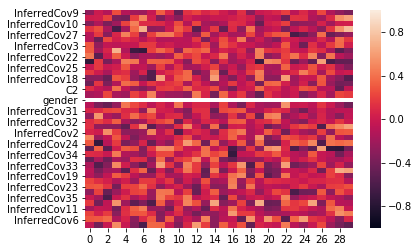

In [50]:
df = build_correlation_matrix(TISSUES['Blood Vessel'][0])
sns.heatmap(df, vmin=-1, vmax=1)

braincerebellum


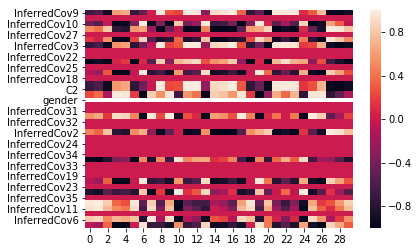

In [51]:
df = build_correlation_matrix(TISSUES['Brain'][0])
sns.heatmap(df, vmin=-1, vmax=1)

colonsigmoid


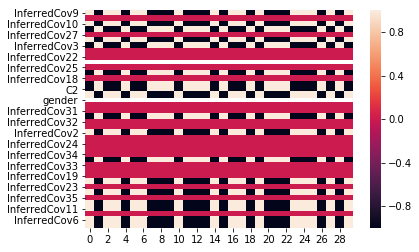

In [52]:
df = build_correlation_matrix(TISSUES['Colon'][0])
sns.heatmap(df, vmin=-1, vmax=1)

esophagusmucosa


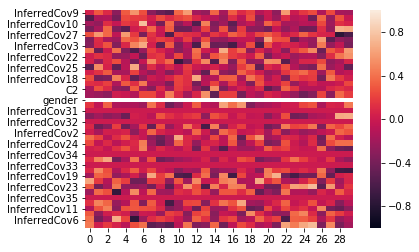

In [53]:
df = build_correlation_matrix(TISSUES['Esophagus'][0])
sns.heatmap(df, vmin=-1, vmax=1)

heartatrialappendage


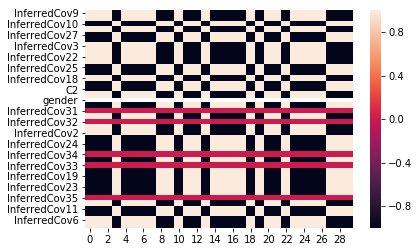

In [54]:
df = build_correlation_matrix(TISSUES['Heart'][0])
sns.heatmap(df, vmin=-1, vmax=1)

liver


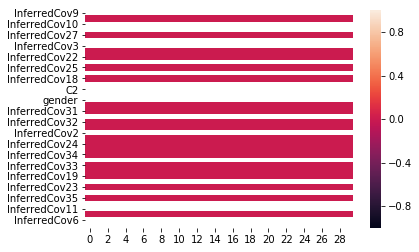

In [55]:
df = build_correlation_matrix(TISSUES['Liver'][0])
sns.heatmap(df, vmin=-1, vmax=1)

lung


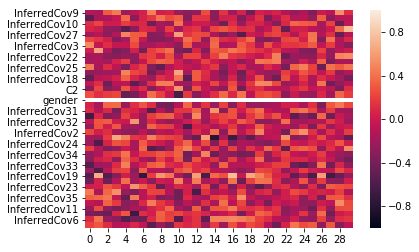

In [56]:
df = build_correlation_matrix(TISSUES['Lung'][0])
sns.heatmap(df, vmin=-1, vmax=1)

muscleskeletal


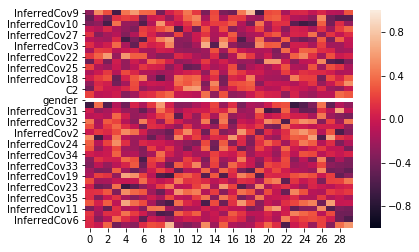

In [57]:
df = build_correlation_matrix(TISSUES['Muscle'][0])
sns.heatmap(df, vmin=-1, vmax=1)

ovary


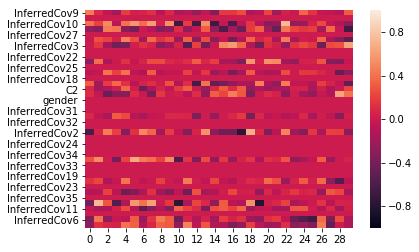

In [58]:
df = build_correlation_matrix(TISSUES['Ovary'][0])
sns.heatmap(df, vmin=-1, vmax=1)

pancreas


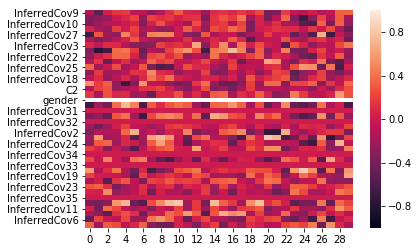

In [59]:
df = build_correlation_matrix(TISSUES['Pancreas'][0])
sns.heatmap(df, vmin=-1, vmax=1)

pituitary


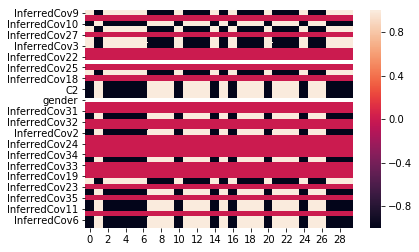

In [60]:
df = build_correlation_matrix(TISSUES['Pituitary'][0])
sns.heatmap(df, vmin=-1, vmax=1)

smallintestineterminalileum


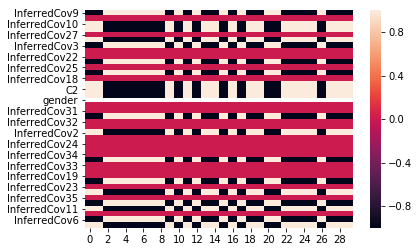

In [61]:
df = build_correlation_matrix(TISSUES['Small Intestine'][0])
sns.heatmap(df, vmin=-1, vmax=1)

stomach


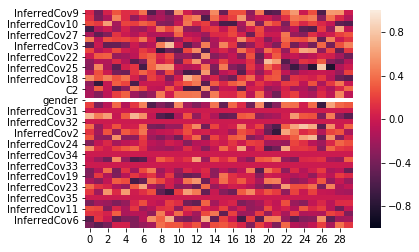

In [62]:
df = build_correlation_matrix(TISSUES['Stomach'][0])
sns.heatmap(df, vmin=-1, vmax=1)

testis


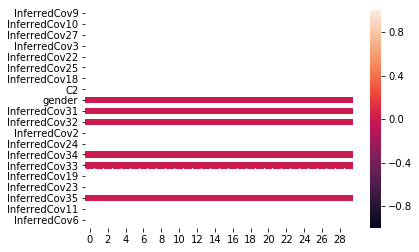

In [63]:
df = build_correlation_matrix(TISSUES['Testis'][0])
sns.heatmap(df, vmin=-1, vmax=1)

thyroid


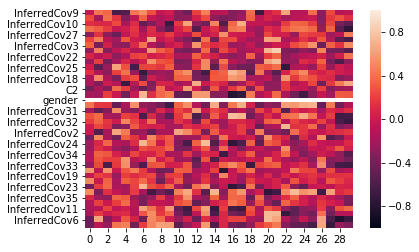

In [64]:
df = build_correlation_matrix(TISSUES['Thyroid'][0])
sns.heatmap(df, vmin=-1, vmax=1)

uterus


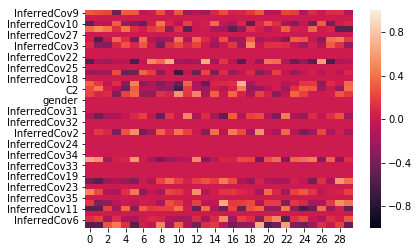

In [65]:
df = build_correlation_matrix(TISSUES['Uterus'][0])
sns.heatmap(df, vmin=-1, vmax=1)

vagina


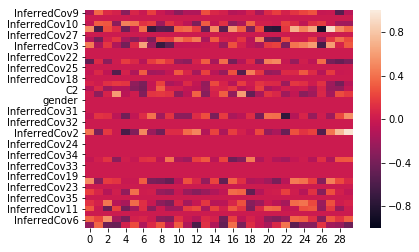

In [66]:
df = build_correlation_matrix(TISSUES['Vagina'][0])
sns.heatmap(df, vmin=-1, vmax=1)